## Data visualization...
*Visualizing the prepped lyric datasets to support further investigation...*
    
#### Sources of inspiration ####
- https://towardsdatascience.com/tf-idf-a-visual-explainer-and-python-implementation-on-presidential-inauguration-speeches-2a7671168550
- https://towardsdatascience.com/building-a-content-based-childrens-book-recommender-for-parents-680e20013e90
- https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f


#### Import tools... ####

In [1]:
# General imports...
import os
import sys
import ast
import requests
import pprint
import json
import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from datetime import datetime
from spotify import spotifyApi
from text_miner import textMiner
from text_miner import geniusApi
from pandas.io.json import json_normalize

# specified imports...
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# importing latest song dataset
data_path = "/Users/dayoorigunwa/code_base/music_mapping/data/"
allfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
encoded_dfs = [filename for filename in allfiles if "encoded_dataset" in filename]
encoded_dfs.sort()
song_df = pd.read_csv(data_path + encoded_dfs[-1])
song_df.info()

# filtering bad data...
song_df = song_df[song_df["lyrics"].notna()]  # 1066 --> 647 :)
song_df = song_df.drop(columns=["Unnamed: 0"])

# setting types...
song_df.date_added = pd.to_datetime(
    song_df["date_added"], format="%Y-%m-%dT%H:%M:%S.%f"
)
song_df["utils_genius_data"] = song_df["utils_genius_data"].apply(
    lambda x: ast.literal_eval(x)
)
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 646 non-null    int64  
 1   name                       646 non-null    object 
 2   artist                     646 non-null    object 
 3   lyrics                     646 non-null    object 
 4   date_added                 646 non-null    object 
 5   energy                     646 non-null    float64
 6   liveness                   646 non-null    float64
 7   tempo                      646 non-null    float64
 8   speechiness                646 non-null    float64
 9   acousticness               646 non-null    float64
 10  instrumentalness           646 non-null    float64
 11  time_signature             646 non-null    float64
 12  danceability               646 non-null    float64
 13  valence                    646 non-null    float64

In [3]:
# dropping 0-length songs from list...
song_df = song_df[song_df["song_length"] > 0]

In [4]:
# creating corpus list from formatted song lyric dataframe...
raw_corpus_list = song_df["lyrics"].dropna().values.tolist()
token_corpus_list = song_df["clean_tokes"].dropna().values.tolist()
stemmed_corpus_list = song_df["stemmed"].dropna().values.tolist()
lemmatized_corpus_list = song_df["lemmatized"].dropna().values.tolist()

In [5]:
# defining TF-IDF analysis for lyrics...
def is_unique(s):
    a = s.to_numpy()  # s.values (pandas<0.24)
    return (a[0] == a).all()


def int_filter(someList):
    for v in someList:
        try:
            int(v)
            continue  # Skip these
        except ValueError:
            yield v  # Keep these


def vectorize_lyrics(corpus):
    """
    This function creates a sparse matrix containing the
    tf-idf for a given list of lyrics. tf-idf means
    term-frequency times inverse document-frequency.
    ngram_range = phrase length (ie. 1,3 would be 1-3 length phrases)
    This is a common term weighting scheme in information retrieval,
    that has also found good use in document classification.
    """
    vectorizer = TfidfVectorizer(
        stop_words="english", ngram_range=(1, 1), max_df=0.6, min_df=0.01
    )
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    return df


def eval_lrics(df):
    data = df.transpose()
    # data.columns = ['document_bush_2001', 'document_obama_2009', 'document_trump_2017', 'document_biden_2021']
    # Find the top 30 words said by each President
    top_dict = {}
    for c in range(4):
        top = data.iloc[:, c].sort_values(ascending=False).head(30)
        top_dict[data.columns[c]] = list(zip(top.index, top.values))
    # Print the top 15 words said by each President
    for president, top_words in top_dict.items():
        print(president)
        print(", ".join([word for word, count in top_words[0:14]]))
        print("---")
    return df


def print_tdif_df(df):
    """
    prints the tdif matrices created above
    in groups of the top 15 most meaningful
    words.
    """
    data = df.transpose()
    # data.columns = list( int_filter( list(data.index) ))
    # data.head()
    top_dict = {}
    for c in range(4):
        top = data.iloc[:, c].sort_values(ascending=False).head(30)
        top_dict[data.columns[c]] = list(zip(top.index, top.values))

    # Print the top 15 words said by each song
    for song, top_words in top_dict.items():
        print(song)
        print(", ".join([word for word, count in top_words[0:14]]))
        print("---")


def make_wordcloud(df):
    """
    generates a wordcloud from list of values provided...
    expects tdif matrix from functions above as input
    """
    wordcols = list(
        int_filter(list(df.columns))
    )  # TODO: those integer columns were probably not mistakes!
    if len(wordcols) > 0:
        col = wordcols[0]
    else:
        print("No suitable columns found")
        return
    # print(df[col])
    wordcloud = WordCloud().generate_from_frequencies(df[col])
    plt.imshow(wordcloud)


def geeks_wordcloud(corpus_list):
    """
    Python program to generate WordCloud
    Thanks to: https://www.geeksforgeeks.org/generating-word-cloud-python/
    Expects a corpus_list, or a list of strings comprising the document being modeled
    """
    comment_words = ""
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in corpus_list:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens) + " "

    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color="white",
        stopwords=stopwords,
        min_font_size=10,
    ).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

In [6]:
# creating corpus list from formatted song lyric dataframe...
raw_tfidf_df = vectorize_lyrics(raw_corpus_list)
token_tfidf_df = vectorize_lyrics(token_corpus_list)
stemmed_tfidf_df = vectorize_lyrics(stemmed_corpus_list)
lemmatized_tfidf_df = vectorize_lyrics(lemmatized_corpus_list)

/Users/dayoorigunwa/.pyenv/versions/3.7.4/envs/music/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Viewing each corpus list as a wordcloud...

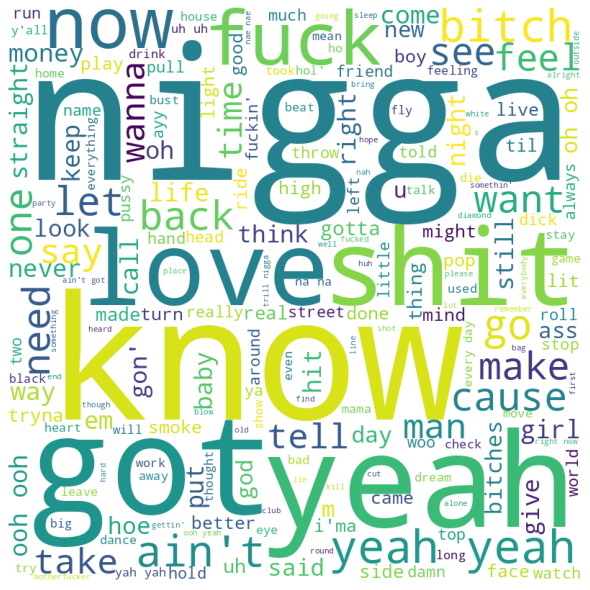

In [7]:
geeks_wordcloud(raw_corpus_list)

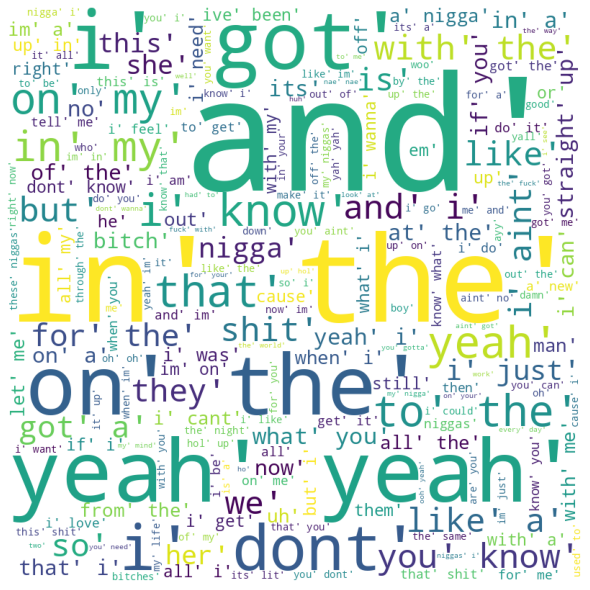

In [8]:
geeks_wordcloud(token_corpus_list)

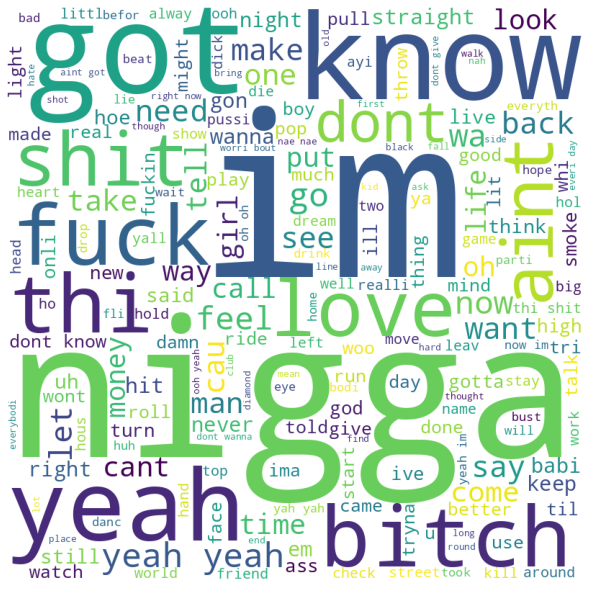

In [9]:
geeks_wordcloud(stemmed_corpus_list)

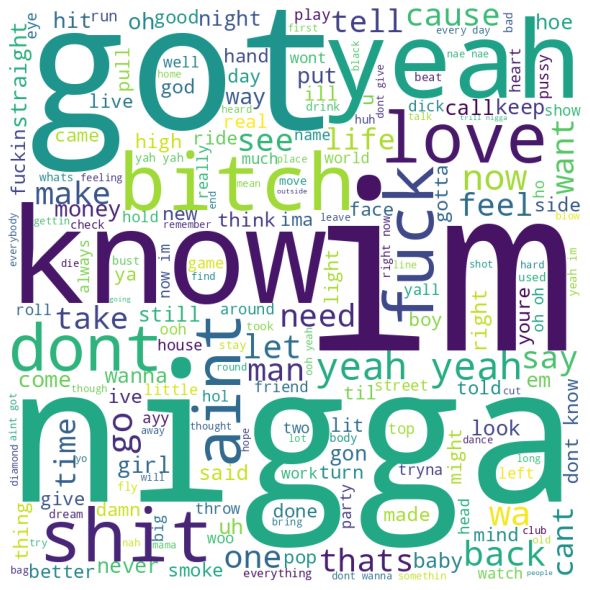

In [10]:
geeks_wordcloud(lemmatized_corpus_list)

### Viewing each extreme feature group as a wordcloud...

In [16]:
# vars...
bin_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
audio_cols = [
    "energy",
    "liveness",
    "tempo",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "time_signature",
    "danceability",
    "valence",
    "duration_ms",
    "loudness",
]
# label types...

# sorting...
feature_vals = []
binned_dfs = dict()
label_cols = {val: val + "_bs_label" for val in audio_cols}
for label in bin_labels:
    binned_dfs[label] = dict()
    for col in audio_cols:
        binned_dfs[label][col] = song_df[song_df[col + "_bs_label"] == label]

# Hello world...
binned_dfs["Very High"]["energy"]

,name,artist,lyrics,date_added,energy,liveness,tempo,speechiness,acousticness,instrumentalness,...,liveness_q_label,tempo_q_label,speechiness_q_label,acousticness_q_label,instrumentalness_q_label,time_signature_q_label,danceability_q_label,valence_q_label,duration_ms_q_label,loudness_q_label
8,Ghetto Symphony,A$AP Rocky,Do just what I tell you ( Uh ) Don't come in ...,2021-09-05 22:06:54+00:00,0.926,0.926,0.926,0.926,0.926,0.926,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High
15,Azul,J Balvin,Le gusta salir y amanecer Beber y enloquecer...,2021-08-24 01:19:21+00:00,0.836,0.836,0.836,0.836,0.836,0.836,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High
19,Location,Bella Alubo,Nini dey You crossing my mind For the 2nd time...,2021-09-22 20:58:31+00:00,0.845,0.845,0.845,0.845,0.845,0.845,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High
28,Kool Aid & Frozen Pizza,Mac Miller,K.I.D.S ( You know what? You know what? You k...,2021-08-27 04:45:49+00:00,0.845,0.845,0.845,0.845,0.845,0.845,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High
42,NO BYSTANDERS,Travis Scott,The party never ends In a motel layin' with m...,2018-08-03 03:46:38+00:00,0.811,0.811,0.811,0.811,0.811,0.811,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,Kiss My (Uh Oh),Anne-Marie,"Uh oh, uh oh-oh-oh Don't wanna hear, one mor...",2021-12-03 05:32:39+00:00,0.878,0.878,0.878,0.878,0.878,0.878,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High
629,I must apologise,PinkPantheress,I never wanted to cast doubt in your mind I'm...,2021-12-03 05:32:39+00:00,0.856,0.856,0.856,0.856,0.856,0.856,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High
635,Pieces of You,"nothing,nowhere.",All the pieces of you fit perfectly in the ho...,2021-12-03 05:32:39+00:00,0.908,0.908,0.908,0.908,0.908,0.908,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High
640,Memory,Kane Brown,"Yeah, yeah, yeah-ayy, yeah Ooh, ooh, ooh, ooh...",2021-12-03 05:32:39+00:00,0.889,0.889,0.889,0.889,0.889,0.889,...,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High,Very High


### Viewing each dataframe's most common lyrics...

In [139]:
# raw df view
print_tdif_df(raw_tdif_df)

0
burn, lights, blood, away, raised, quiet, passed, falling, moment, came, life, feel, probably, problem
---
1
said, prayer, diamond, forever, fine, coming, dead, round, stop, night, ve, purple, purp, pull
---
2
mama, tell, line, fine, wait, fall, gone, heart, feel, walk, proper, prove, public, pullin
---
3
sold, remember, soul, love, drug, sun, die, pulled, prove, public, pull, 10, proper, pulling
---


In [140]:
# token df view
print_tdif_df(token_tdif_df)

0
burn, lights, blood, away, raised, quiet, passed, falling, moment, theres, came, life, feel, purple
---
1
youd, said, prayer, diamond, youve, forever, fine, coming, dead, round, stop, night, purse, push
---
2
mama, tell, line, fine, wait, fall, gone, heart, feel, walk, problem, problems, pussy, pushin
---
3
sold, remember, soul, love, drug, sun, die, purse, punch, purp, purple, 10, pulling, push
---


In [141]:
# stemmed df view
print_tdif_df(stemmed_tdif_df)

0
burn, blood, away, light, quiet, slip, rais, moment, pass, fall, came, life, feel, punch
---
1
youd, said, answer, prayer, youv, forev, fine, dead, round, diamond, stop, alway, live, night
---
2
mama, tell, line, fine, gone, fall, wait, heart, feel, wa, walk, proper, protect, prove
---
3
hook, sold, rememb, soul, love, sun, drug, die, pin, promis, push, purs, purpl, purp
---


In [142]:
# lemmatized df view
print_tdif_df(lemmatized_tdif_df)

0
burn, blood, away, light, raised, quiet, slip, passed, falling, moment, came, life, feel, reckless
---
1
youd, said, prayer, youve, forever, fine, coming, dead, round, diamond, stop, night, life, wa
---
2
mama, tell, line, fine, wait, fall, gone, heart, feel, wa, walk, po, rain, radio
---
3
sold, remember, soul, love, sun, drug, die, quavo, que, queen, quest, quick, question, putting
---


### ...as WordClouds

In [146]:
# print_tdif_df(raw_tdif_df)
make_wordcloud(raw_tdif_df)

TypeError: argument of type 'int' is not iterable

### Sanity checks...

In [17]:
# raw lyrics tdif matrix
raw_tdif_df.tail()

,10,100,11,12,15,20,21,24,25,2pac,...,yo,york,young,yuh,yup,zip,zombie,zone,zoo,zoom
641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
# tokenized lyrics tdif matrix
token_tdif_df.head()

,10,100,12,15,20,21,25,2pac,30,40,...,youre,yous,youve,yuh,yup,zip,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.235021,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.258703,0.0,0.266848,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# stemmed lyrics tdif matrix
stemmed_tdif_df.head()

,10,100,12,15,20,21,25,2pac,30,40,...,young,youngin,youv,yuh,yup,zip,zombi,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.227932,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.341710,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
# lemmatized lyrics tdif matrix
lemmatized_tdif_df.head()

,10,100,12,15,20,21,25,2pac,30,40,...,youre,yous,youve,yuh,yup,zip,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.236610,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.260973,0.0,0.269246,0.0,0.0,0.0,0.0,0.0,0.0,0.0
